# The Variance Gamma Partial Integro-Differential Equation

## Contents
   - [The VG PIDE](#sec1)
      - [Euristic derivation](#sec1.1)
      - [Implicit discretization](#sec1.2)
   - [Introduction to sparse matrices](#sec2)
   - [Numerical solution of the PDE](#sec3)


<a id='sec1'></a>
## The VG PIDE   

The VG PIDE has the following form:    

$$
  \frac{\partial V(t,x)}{\partial t} +
 \bigl( r-\frac{1}{2}\sigma_{\epsilon}^2 - w_{\epsilon} \bigr) \frac{\partial V(t,x)}{\partial x} 
 + \frac{1}{2}\sigma_{\epsilon}^2 \frac{\partial^2 V(t,x)}{\partial x^2}
 + \int_{|z| \geq \epsilon} V(t,x+z) \nu(dz) = (\lambda_{\epsilon} + r) V(t,x).
$$

with parameters   

$$
  \sigma_{\epsilon}^2 :=  \int_{|z| < \epsilon} z^2 \nu(dz), \quad \quad w_{\epsilon} := \int_{|z| \geq \epsilon} (e^z-1) \nu(dz), \quad \quad
 \lambda_{\epsilon} :=  \int_{|z| \geq \epsilon} \nu(dz) .
$$

and Lévy measure:   

$$
 \nu(dx) = \frac{e^{\frac{\theta x}{\bar\sigma^2}}}{\kappa|x|} \exp 
 \left( - \frac{\sqrt{\frac{2}{\kappa} + \frac{\theta^2}{\bar\sigma^2}}}{\bar\sigma} |x|\right) dx,
$$

This equation is almost identical to equation (\ref{Merton_PIDE}), except for the truncation in the integral. 
At this point we can restrict the computational domain on $[A_1,A_2]$ and the integral region on $[-B_1,B_2]$ and using the same discretization
used for the Merton PIDE, we can solve the problem with the IMEX scheme.\\


In [1]:
from scipy import sparse
from scipy.sparse.linalg import splu

import numpy as np
import scipy as scp
import scipy.stats as ss
from IPython.display import display
import sympy; sympy.init_printing()
from scipy import signal
from scipy.integrate import quad
import matplotlib.pyplot as plt

def display_matrix(m):
    display(sympy.Matrix(m))

In [6]:
r = 0.1
theta = -0.1; sigma = 0.2; kappa = 0.1  
omega = - np.log(1 - theta * kappa - kappa/2 * sigma**2 ) /kappa
dev_X = np.sqrt(sigma**2 + theta**2 * kappa)     # std VG process

S0 = 100; X0 = np.log(S0)          
K = 100; Texpir = 1            

Nspace = 7   # M space steps 7
Ntime = 3    # N time steps  3 
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

dx = (x_max - x_min)/(Nspace-1)
extraP = int(np.floor(3*dev_X/dx))
x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization

In [349]:
A = theta/(sigma**2)
B = np.sqrt( theta**2 + 2*sigma**2/kappa ) / sigma**2

levy_m = lambda y: np.exp( A*y - B*np.abs(y) ) / (kappa*np.abs(y))   # Levy measure VG

In [350]:
extraP

In [351]:
Payoff = np.maximum(np.exp(x)-K,0)             # Call payoff
V = np.zeros((Nspace + 2*extraP, Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms

V[:,-1] = Payoff                   # terminal conditions 
V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) - \
                 K * np.exp(-r* T[::-1] ) * np.ones((extraP+1,Ntime))  # boundary condition
V[:extraP,:] = 0

In [352]:
#display_matrix(V)

In [353]:
eps = 1.5*dx    # the cutoff near 0

lam = quad(levy_m,-(extraP+1.5)*dx,-eps)[0] + quad(levy_m,eps,(extraP+1.5)*dx)[0] # approximated intensity

int_w = lambda y: (np.exp(y)-1) * levy_m(y)
int_s = lambda y: np.abs(y) * np.exp( A*y - B*np.abs(y) ) / kappa  # avoid division by zero

w = quad(int_w, -(extraP+1.5)*dx, -eps)[0] \
       + quad(int_w, eps, (extraP+1.5)*dx)[0]   # is the approx of omega

sig2 = quad(int_s,-eps,eps)[0]                   # the small jumps variance
sigJ = quad(int_s, -(extraP+1.5)*dx, -eps)[0] \
       + quad(int_s, eps, (extraP+1.5)*dx)[0]   # big jumps variance

eps =  0.0004709011095877023


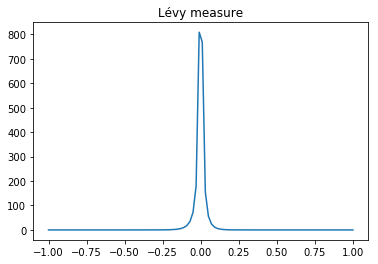

The intensity lam=79.738193 is very small because the mass is concentrated inside [-eps,eps].

Omega:  -0.0796816964917688
Approximated Omega: w =  -0.07967726290396099
Integral inside the truncation near 0:  -4.4057551702031406e-06


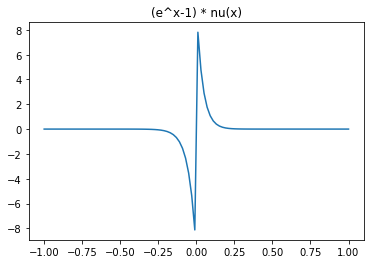

The VG variance 0.041000 is equal to the sum of the Var of the decomposed processes 0.041000.
Under this discretization the diffusion variance 0.000002 is the major component. 


In [354]:
print("eps = ", eps)
plt.plot(np.linspace(-1,1,100), levy_m(np.linspace(-1,1,100))); plt.title("Lévy measure"); plt.show()
print("The intensity lam={:.6f} \
is very small because the mass is concentrated inside [-eps,eps].".format(lam))
print("")

print("Omega: ", omega)
print("Approximated Omega: w = ", w)
print("Integral inside the truncation near 0: ", quad(int_w, -eps, 1e-10)[0] + quad(int_w, 1e-10, eps)[0])
plt.plot(np.linspace(-1,1,100), int_w(np.linspace(-1,1,100))); plt.title("(e^x-1) * nu(x)"); plt.show()

print("The VG variance {0:.6f} is equal to the sum of the Var of the decomposed \
processes {1:.6f}.".format(sigJ + sig2, dev_X**2) )
print("Under this discretization the diffusion variance {:.6f} is the major component. ".format(sig2))

In [355]:
dxx = dx * dx
a = ( (dt/2) * ( (r-w-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r + lam) )
c = (-(dt/2) * ( (r-w-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

In [356]:
nu = np.zeros(2*extraP+3)        # Lévy measure vector
x_med = extraP+1                 # middle point in nu vector
x_nu = np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2) )    # integration domain

for i in range(len(nu)):
    if (i==x_med) or (i==x_med-1) or (i==x_med+1):
        nu[i] = 1e-15
        continue
    nu[i] = quad(levy_m, x_nu[i], x_nu[i+1])[0]

In [357]:
%%time
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="auto")
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset ) 

CPU times: user 8.74 s, sys: 64 ms, total: 8.8 s
Wall time: 8.8 s


In [358]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

13.167315652646266


In [345]:
J = np.zeros((Nspace-2, Nspace + 2*extraP))

for i in range(Nspace-2):
    J[i, i:(len(nu)+i)] = nu

In [346]:
%%time
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[extraP,i]
    offset[-1] = c * V[-1-extraP,i]
    V_jump = V[extraP+1 : -extraP-1, i+1] + dt * (J @ V[:,i+1])
    V[extraP+1 : -extraP-1, i] = DD.solve( V_jump - offset )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 220 µs


Remember to mention that it is necessary to flip the nu  because of different definitions. For Merton is the same since nu is symmetric.

In [360]:
VVV1 = signal.convolve(Payoff, nu[::-1], mode="valid", method="auto")
VVV1

array([ 3.40675839e-12, -8.51689597e-13,  6.81351678e-12, ...,
        1.59012393e+04,  1.59087357e+04,  1.59162344e+04])

In [359]:
signal.convolve?

In [1]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process, VG_process
from functions.BS_pricer import BS_pricer
from functions.VG_pricer import VG_pricer
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=15, K=15, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
VG_param = VG_process(r=0.1, sigma=0.2, theta=-0.2, kappa=2.5)
diff_param = Diffusion_process(r=0.1, sig=np.sqrt(VG_param.var))   

print("standard deviation: ", np.sqrt(VG_param.var) )
print("skewness: ", VG_param.skew)
print("kurtosis: ", VG_param.kurt)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)
VG = VG_pricer(opt_param, VG_param)

standard deviation:  0.37416573867739417
skewness:  -3.05441419328485
kurtosis:  14.387755102040819


In [61]:
BS.PDE_price((7000,4000), Time=True)

(2.908103823849625, 1.4802916049957275)

In [62]:
VG.PIDE_price((7000,4000), Time=True)

(2.2938035665666563, 8.549956560134888)

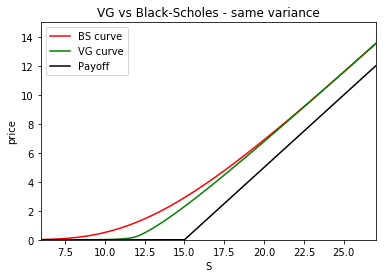

In [64]:
plt.plot(BS.S_vec, BS.price_vec, color='red',label="BS curve")
plt.plot(VG.S_vec, VG.price_vec, color='green',label="VG curve")
plt.plot(VG.S_vec, VG.payoff_f(VG.S_vec), color='black',label="Payoff")
plt.axis([6, 27, 0, 15])
plt.xlabel("S"); plt.ylabel("price"); plt.title("VG vs Black-Scholes - same variance")
plt.legend()
#plt.savefig("VG-BS_theta_negative.png")